# CNN, RNN, LSTM, Transformer 之演進

In [6]:
import tensorflow as tf

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [8]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Convolutional Neural Network (CNN)
### 使用CNN搭配CIFAR影像集來做圖像辨識

In [9]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 860s 5us/step


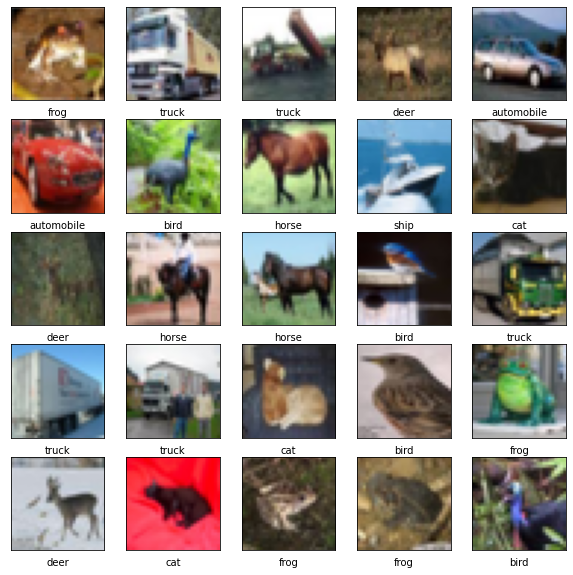

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 建立我們的CNN模型架構

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

### 我們最後加上Dense層(要把矩陣拉平，因為CNN是supervise learning，我們總共的target有10個物品要分類)

In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10


2022-07-11 10:39:08.223694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-07-11 10:39:26.355656: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 39s 9ms/step - loss: 1.5265 - accuracy: 0.4414 - val_loss: 1.2998 - val_accuracy: 0.5355
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1495 - accuracy: 0.5940 - val_loss: 1.0912 - val_accuracy: 0.6102
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9968 - accuracy: 0.6517 - val_loss: 0.9517 - val_accuracy: 0.6664
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8936 - accuracy: 0.6872 - val_loss: 0.8922 - val_accuracy: 0.6906
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8194 - accuracy: 0.7125 - val_loss: 0.8934 - val_accuracy: 0.6892
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7558 - accuracy: 0.7352 - val_loss: 0.8724 - val_accuracy: 0.7005
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7034 - accuracy: 0.7546 - val_loss: 0.8244 - val_accuracy: 0.

313/313 - 2s - loss: 0.8665 - accuracy: 0.7115 - 2s/epoch - 7ms/step


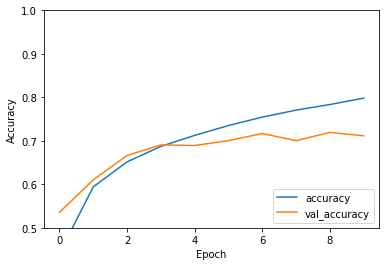

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [17]:
print(test_acc)

0.7114999890327454


## Recurrent Neural Networks (RNN)
使用RNN來製作一個自動產生文字的機器

In [18]:
import numpy as np
import os
import time

### 下載 public dataset

In [19]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [20]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [21]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [22]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### 資料前處理
#### 把文字轉成向量

雖然看起來電腦是在處理文字，但是其實還是向量運算。所以我們必須要先把文字轉換成向量。

In [23]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [24]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [25]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [26]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [27]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [28]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### 建立訓練集 & 目標
因為RNN算是 supervise learning，我們必須要在訓練的時候告訴機器答案。
這邊有個重點要注意，訓練的目標的長度要相同，如果字數過少要記得填空。

In [29]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [30]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [31]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [32]:
seq_length = 100

In [33]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


可以看到每一排的長度都是100

In [34]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy(), len(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou ' 101
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k' 101
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki" 101
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d" 101
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi' 101


In [35]:
#* 這個是挪動一個字元的function
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [36]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [37]:
dataset = sequences.map(split_input_target)

In [38]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [39]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### 建立RNN模型
我們這邊使用GRU層來處理遞迴 (LSTM的改進)
<img src="http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png">

In [40]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [41]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [42]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_training.png">

In [43]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [44]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_2 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [45]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [46]:
sampled_indices

array([23, 61, 56, 16, 24, 14, 16, 49, 43, 45, 15, 16, 22, 57, 18, 27, 34,
       43,  6, 62, 16, 19, 27, 40,  6, 17, 41, 35, 18, 37, 39, 62, 22, 64,
       65, 63, 18,  9, 20, 18, 46, 60, 63, 24, 27,  9, 31,  7, 27, 64, 26,
       31, 38, 24, 24, 48,  2, 10, 23,  0, 56, 27, 60, 63, 22, 16, 26, 16,
       21, 33,  7, 58, 64, 31, 15, 58, 59, 64, 64, 43,  0, 43,  6, 52, 44,
       26, 43, 42, 65, 24, 13, 13, 53, 56, 49, 64, 14, 30, 46,  9])

### 在開始訓練之前使用還沒訓練過的模型來產生看看結果。

In [47]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'back!\nThat jade hath eat bread from my royal hand;\nThis hand hath made him proud with clapping him.\n'

Next Char Predictions:
 b"JvqCKACjdfBCIrENUd'wCFNa'DbVEXZwIyzxE.GEguxKN.R,NyMRYKKi 3J[UNK]qNuxICMCHT,syRBstyyd[UNK]d'meMdczK??nqjyAQg."


In [48]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [49]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.188756, shape=(), dtype=float32)


In [50]:
tf.exp(example_batch_mean_loss).numpy()

65.94071

### 使用Adam策略來調整訓練過程。 loss function使用 SparseCategoricalCrossentropy

In [51]:
model.compile(optimizer='adam', loss=loss)

In [52]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [53]:
EPOCHS = 20

In [54]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 12s 49ms/step - loss: 2.7144
Epoch 2/20
172/172 [==============================] - 13s 67ms/step - loss: 1.9845
Epoch 3/20
172/172 [==============================] - 10s 48ms/step - loss: 1.7078
Epoch 4/20
172/172 [==============================] - 9s 48ms/step - loss: 1.5479
Epoch 5/20
172/172 [==============================] - 10s 52ms/step - loss: 1.4493
Epoch 6/20
172/172 [==============================] - 10s 49ms/step - loss: 1.3810
Epoch 7/20
172/172 [==============================] - 10s 51ms/step - loss: 1.3282
Epoch 8/20
172/172 [==============================] - 11s 51ms/step - loss: 1.2830
Epoch 9/20
172/172 [==============================] - 12s 63ms/step - loss: 1.2409
Epoch 10/20
172/172 [==============================] - 26s 133ms/step - loss: 1.2012
Epoch 11/20


2022-07-11 10:44:24.559430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4297 of 10000
2022-07-11 10:44:34.551453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7373 of 10000
2022-07-11 10:44:44.552682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 58s 161ms/step - loss: 1.1616
Epoch 12/20


2022-07-11 10:45:22.782189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9049 of 10000
2022-07-11 10:45:23.688142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 33s 129ms/step - loss: 1.1217
Epoch 13/20


2022-07-11 10:45:56.095766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8348 of 10000
2022-07-11 10:45:57.926101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 50s 222ms/step - loss: 1.0781
Epoch 14/20


2022-07-11 10:46:46.339875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3700 of 10000
2022-07-11 10:46:56.338678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7957 of 10000
2022-07-11 10:47:01.732691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 60s 200ms/step - loss: 1.0324
Epoch 15/20


2022-07-11 10:47:46.482576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8039 of 10000
2022-07-11 10:47:48.754628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 39s 154ms/step - loss: 0.9855
Epoch 16/20


2022-07-11 10:48:27.451589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7559 of 10000
2022-07-11 10:48:30.304553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 55s 247ms/step - loss: 0.9360
Epoch 17/20


2022-07-11 10:49:22.851632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2819 of 10000
2022-07-11 10:49:32.851384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6447 of 10000
2022-07-11 10:49:41.712017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 58s 165ms/step - loss: 0.8837
Epoch 18/20


2022-07-11 10:50:20.505702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6928 of 10000
2022-07-11 10:50:24.886035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 66s 297ms/step - loss: 0.8336
Epoch 19/20


2022-07-11 10:51:26.280975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2232 of 10000
2022-07-11 10:51:36.279823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4468 of 10000
2022-07-11 10:51:46.285552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7378 of 10000
2022-07-11 10:51:51.276066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 71s 208ms/step - loss: 0.7825
Epoch 20/20


2022-07-11 10:52:37.988653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6527 of 10000
2022-07-11 10:52:42.843411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


172/172 [==============================] - 45s 175ms/step - loss: 0.7332


### 透過History可以看到訓練的過程loss一直在往下降。

In [55]:
history.history

{'loss': [2.7143776416778564,
  1.9845277070999146,
  1.7077608108520508,
  1.5478805303573608,
  1.449292778968811,
  1.3810222148895264,
  1.328189730644226,
  1.283016324043274,
  1.240936517715454,
  1.2011775970458984,
  1.1616240739822388,
  1.1216598749160767,
  1.078076720237732,
  1.032421350479126,
  0.9854704141616821,
  0.9359843134880066,
  0.8837234973907471,
  0.83364337682724,
  0.7825480699539185,
  0.7331694960594177]}

### 訓練完成，開始產生文字
<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png">

In [56]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states

In [57]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [58]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:']) #* 設定我們起始的文字
result = [next_char]

for n in range(500): #* 設定我們想要產生的句子長度
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
What twenty? Edward!'s queen may in the popular
things that you lose your honour trift a money?

AmONILAND:
Nay, my dear lipbre, you are come to keep and saved.

YORK:
What shall we do?

DUKE OF YORK:
He may live.

GRUMIO:
Yes, if you please, in mine opinion, ours,
As thought of this: 'tis not a man may.

GLOUCESTER:

HENRY BOLINGBROKE:
Faith, none son; let me go like sword,
And made thy brother lived: by your honour,
'he it may: I believe it forth
Thou pullest noble Nuclabbry;
Which my own dau 

________________________________________________________________________________

Run time: 25.052436113357544


### 儲存&載入我們訓練好的模型

In [59]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [60]:
states = None
next_char = tf.constant(['RUBY:'])
result = [next_char]

for n in range(100):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

RUBY:
Fail on't, I scarcely know myself:
'Tis not to death: 'tis mine; I must accord:
I know not what the


## Transformer
使用Transformer製作一個翻譯模型

In [61]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

### 匯入資料

In [ ]:
train_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_train.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
test_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_test.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
dev_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_dev.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])

In [ ]:
for examples in train_data.batch(3).take(1):
    for i in examples.keys():
        print(i)
        # for en in en_examples.numpy():
        #     print(en.decode('utf-8'))
        # for zh in zh_examples.numpy():
        #     print(zh.decode('utf-8'))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

## Recurrent Neural Networks (RNN)
使用RNN來製作一個自動產生文字的機器

In [ ]:
import numpy as np
import os
import time

### 下載 public dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

### 資料前處理
#### 把文字轉成向量

雖然看起來電腦是在處理文字，但是其實還是向量運算。所以我們必須要先把文字轉換成向量。

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### 建立訓練集 & 目標
因為RNN算是 supervise learning，我們必須要在訓練的時候告訴機器答案。
這邊有個重點要注意，訓練的目標的長度要相同，如果字數過少要記得填空。

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq))

可以看到每一排的長度都是100

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy(), len(seq))

In [ ]:
#* 這個是挪動一個字元的function
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

### 建立RNN模型
我們這邊使用GRU層來處理遞迴 (LSTM的改進)
<img src="http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png">

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_training.png">

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
model.summary()

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

### 在開始訓練之前使用還沒訓練過的模型來產生看看結果。

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

### 使用Adam策略來調整訓練過程。 loss function使用 SparseCategoricalCrossentropy

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

### 透過History可以看到訓練的過程loss一直在往下降。

In [ ]:
history.history

### 訓練完成，開始產生文字
<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png">

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:']) #* 設定我們起始的文字
result = [next_char]

for n in range(500): #* 設定我們想要產生的句子長度
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

### 儲存&載入我們訓練好的模型

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['RUBY:'])
result = [next_char]

for n in range(100):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

## Transformer
使用Transformer製作一個翻譯模型

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

### 匯入資料

In [ ]:
train_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_train.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
test_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_test.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
dev_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_dev.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])

In [ ]:
for examples in train_data.batch(3).take(1):
    for i in examples.keys():
        print(i)
        # for en in en_examples.numpy():
        #     print(en.decode('utf-8'))
        # for zh in zh_examples.numpy():
        #     print(zh.decode('utf-8'))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

## Recurrent Neural Networks (RNN)
使用RNN來製作一個自動產生文字的機器

In [ ]:
import numpy as np
import os
import time

### 下載 public dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

### 資料前處理
#### 把文字轉成向量

雖然看起來電腦是在處理文字，但是其實還是向量運算。所以我們必須要先把文字轉換成向量。

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### 建立訓練集 & 目標
因為RNN算是 supervise learning，我們必須要在訓練的時候告訴機器答案。
這邊有個重點要注意，訓練的目標的長度要相同，如果字數過少要記得填空。

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq))

可以看到每一排的長度都是100

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy(), len(seq))

In [ ]:
#* 這個是挪動一個字元的function
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

### 建立RNN模型
我們這邊使用GRU層來處理遞迴 (LSTM的改進)
<img src="http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png">

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_training.png">

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
model.summary()

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

### 在開始訓練之前使用還沒訓練過的模型來產生看看結果。

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

### 使用Adam策略來調整訓練過程。 loss function使用 SparseCategoricalCrossentropy

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

### 透過History可以看到訓練的過程loss一直在往下降。

In [ ]:
history.history

### 訓練完成，開始產生文字
<img src="https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png">

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:']) #* 設定我們起始的文字
result = [next_char]

for n in range(500): #* 設定我們想要產生的句子長度
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

### 儲存&載入我們訓練好的模型

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['RUBY:'])
result = [next_char]

for n in range(100):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

## Transformer
使用Transformer製作一個翻譯模型

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

### 匯入資料

In [ ]:
train_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_train.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
test_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_test.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])
dev_data = tf.data.experimental.make_csv_dataset(file_pattern='data/ted_data/all_talks_dev.tsv', field_delim='\t', batch_size=1, select_columns=['en', 'zh-tw'])

In [ ]:
for examples in train_data.batch(3).take(1):
    for i in examples.keys():
        print(i)
        # for en in en_examples.numpy():
        #     print(en.decode('utf-8'))
        # for zh in zh_examples.numpy():
        #     print(zh.decode('utf-8'))